In [10]:
from Tools import *

In [11]:
Detailed_gas = ct.Solution("detailed.yaml")
Reduced_gas = ct.Solution("reduced.yaml")
Optim_1 = ct.Solution("/work/kotlarcm/WORK/V2/Orion/Start_mpi_pop10_gen100_PyOptMECH_Case1/mech/Mech_gen_1.yaml")
Optim_100 = ct.Solution("/work/kotlarcm/WORK/V2/Orion/Start_mpi_pop10_gen100_PyOptMECH_Case1/Reduced_mpi_pop_PyOptMECH.yaml")
pressure = np.linspace(1,1,1).tolist()
temperature = np.linspace(1500,1500,1).tolist()
phi = np.linspace(1,1,1).tolist()
mixture =np.linspace(0.85,0.85,1).tolist()


Targets = ["H2", "NH3", "O2", "OH","NO", 'H2O','NO2', 'N2O','N2']
Non_Target = ['H', 'O', 'HO2', 'N', 'N2H3', 'N2H2', 'HNO',"NH","NH2","NNH"]

param = ["shift","interpol","noscaler"]

fuel1 = "NH3"
fuel2 ="H2"
oxidizer = 'O2:0.21, N2:0.79, AR : 0.01' 
tmax = 1
dt= 1e-6
case = generate_test_cases_bifuel(temperature,pressure,phi,mixture)
idx_target_det = spcs_name_idx(Detailed_gas,Targets)
idx_target_red = spcs_name_idx(Reduced_gas,Targets)

idx_non_target_det = spcs_name_idx(Detailed_gas,Non_Target)
idx_non_target_red = spcs_name_idx(Reduced_gas,Non_Target)


/tmp/ipykernel_845301/3695144978.py:1: UserWarning: NasaPoly2::validate: 
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  Detailed_gas = ct.Solution("detailed.yaml")


In [12]:
Time_det , Temp_det, Y_Target_det,Y_Non_Target_det = Sim0D_launch(Detailed_gas,Detailed_gas,fuel1,fuel2,oxidizer,case,idx_target_det,idx_non_target_det,dt,tmax)
Time_det , Temp_det, Y_Target_det,Y_Non_Target_det, Scaler_Target_det,Scaler_Non_Target_det,AI_delay_det,Temp_scaler = Change_detailed(Time_det,Temp_det,Y_Target_det,Y_Non_Target_det,case,Targets,Non_Target,param) # transform 

In [13]:
Time_red , Temp_red, Y_Target_red,Y_Non_Target_red = Sim0D_launch(Reduced_gas,Reduced_gas,fuel1,fuel2,oxidizer,case,idx_target_red,idx_non_target_red,dt,tmax) 
        #transform (Shift, Interp, Scal)
Time_red , Temp_red, Y_Target_red,Y_Non_Target_red,AI_delay_red =Change_Reduced(Time_red,Temp_red,Y_Target_red,Y_Non_Target_red,case,Targets,Non_Target,Time_det,Scaler_Target_det,Scaler_Non_Target_det,Temp_scaler,param)

In [14]:
Time_red_optim1, Temp_red_optim1, Y_Target_red_optim1,Y_Non_Target_red_optim1 = Sim0D_launch(Optim_1,Optim_1,fuel1,fuel2,oxidizer,case,idx_target_red,idx_non_target_red,dt,tmax) 
        #transform (Shift, Interp, Scal)
Time_red_optim1 , Temp_red_optim1, Y_Target_red_optim1,Y_Non_Target_red_optim1,AI_delay_red_optim1 =Change_Reduced(Time_red_optim1,Temp_red_optim1,Y_Target_red_optim1,Y_Non_Target_red_optim1,case,Targets,Non_Target,Time_det,Scaler_Target_det,Scaler_Non_Target_det,Temp_scaler,param)

In [15]:
Time_red_optim100, Temp_red_optim100, Y_Target_red_optim100,Y_Non_Target_red_optim100 = Sim0D_launch(Optim_100,Optim_100,fuel1,fuel2,oxidizer,case,idx_target_red,idx_non_target_red,dt,tmax) 
        #transform (Shift, Interp, Scal)
Time_red_optim100 , Temp_red_optim100, Y_Target_red_optim100,Y_Non_Target_red_optim100,AI_delay_red_optim100 =Change_Reduced(Time_red_optim100,Temp_red_optim100,Y_Target_red_optim100,Y_Non_Target_red_optim100,case,Targets,Non_Target,Time_det,Scaler_Target_det,Scaler_Non_Target_det,Temp_scaler,param)

In [20]:

def fit_pyoptmec(Y_t_red,Y_t_det,time_det,Y_nt_red,Y_nt_det,temp_red,temp_det,ai_det,ai_red,case) : 
    F1_m =[]
    F2_m =[]
    F3_m =[] 
    F4_m = []
    for c in range(len(case)) : 
        # Equation F1_m
        top1 = np.trapezoid(np.abs(np.array(Y_t_red[c]) - np.array(Y_t_det[c])), np.array(time_det[c]))
        bot1 = np.trapezoid(np.abs(np.array(Y_t_det[c])), np.array(time_det[c]))
        F1_m.append( (top1/bot1)**2)

        # Equation F2_m
        top2 = [(np.max(Y_nt_red[c],axis=1)[j] - np.max(Y_nt_det[c],axis=1)[j]) for j in range(len(np.max(Y_nt_det[c],axis=1))) ]
        bot2 = [np.max(Y_nt_det[c],axis=1)[j] for j in range(len(np.max(Y_nt_det[c],axis=1))) ]
    
        F2_m.append((np.array(top2)/np.array(bot2))**2)

        # Equation F3_m
        top3 = np.trapezoid(np.abs(temp_red[c] - temp_det[c]), time_det[c])
        bot3 = np.trapezoid(np.abs(temp_det[c]), time_det[c])
        F3_m .append(( top3/ bot3)**2)

        # Equation F4_m
        top4 = (ai_red[c] - ai_det[c])
        bot4= ai_det[c]
        F4_m.append((top4/bot4)**2)
        
    weight = [1,1,1,1]
    # print(f"F1 = {F1_m}")
    # print(f"F2 = {F2_m}")
    
    _err = (
                weight[0] * np.sum(F1_m)
                + weight[1] * np.sum(F2_m)
                + weight[2] * F3_m
                + weight[3] * F4_m
            )
    # print(f"Err : {_err}")

    err = np.sqrt(np.sum(_err))
    print(np.sqrt(np.sum(_err)))
    return err,F1_m,F2_m,F3_m,F4_m


In [28]:
Err,F1,F2,F3,F4 = fit_pyoptmec(Y_Target_red,Y_Target_det,Time_det,Y_Non_Target_red,Y_Non_Target_det,Temp_red,Temp_det,AI_delay_det,AI_delay_red,case)
Err_1 ,F1_1,F2_1,F3_1,F4_1 = fit_pyoptmec(Y_Target_red_optim1,Y_Target_det,Time_det,Y_Non_Target_red_optim1,Y_Non_Target_det,Temp_red_optim1,Temp_det,AI_delay_det,AI_delay_red_optim1,case)

Err_100 ,F1_100,F2_100,F3_100,F4_100 = fit_pyoptmec(Y_Target_red_optim100,Y_Target_det,Time_det,Y_Non_Target_red_optim100,Y_Non_Target_det,Temp_red_optim100,Temp_det,AI_delay_det,AI_delay_red_optim100,case)


1.1314257532243612
1.7064447081954441
1.4266620266882317


Text(0.5, 1.0, 'F3 et F4')

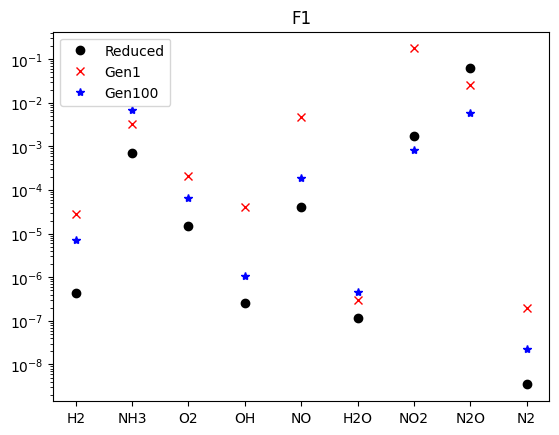

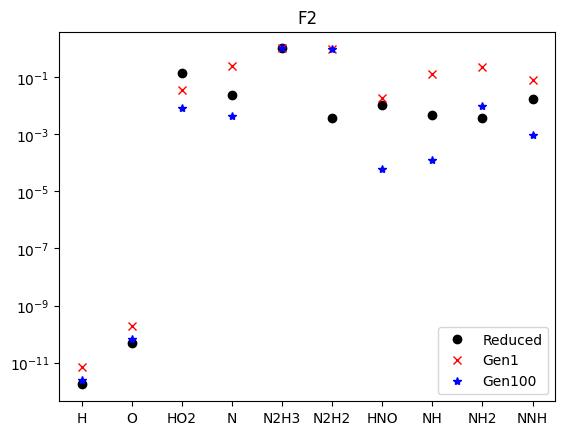

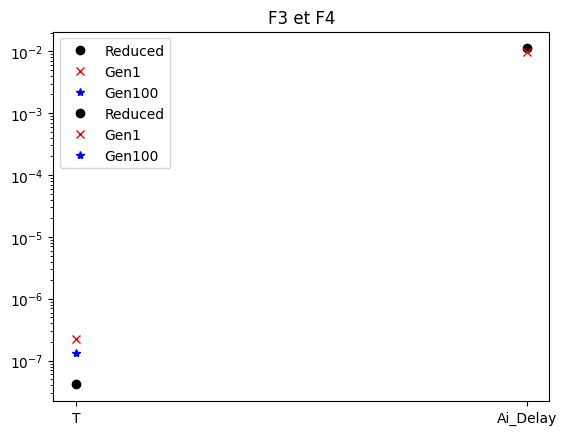

In [42]:
plt.figure()
plt.plot(Targets,F1[0],'ko',label="Reduced")
plt.plot(Targets,F1_1[0],'rx',label="Gen1")
plt.plot(Targets,F1_100[0],'b*',label="Gen100")
plt.legend()
plt.yscale("log")
plt.title("F1")

plt.figure()
plt.plot(Non_Target,F2[0],'ko',label="Reduced")
plt.plot(Non_Target,F2_1[0],'rx',label="Gen1")
plt.plot(Non_Target,F2_100[0],'b*',label="Gen100")
plt.legend()
plt.yscale("log")
plt.title("F2")

plt.figure()
plt.plot(["T"],F3[0],'ko',label="Reduced")
plt.plot(["T"],F3_1[0],'rx',label="Gen1")
plt.plot(["T"],F3_100[0],'b*',label="Gen100")
plt.plot(["Ai_Delay"],F4[0],'ko',label="Reduced")
plt.plot(["Ai_Delay"],F4_1[0],'rx',label="Gen1")
plt.plot(["Ai_Delay"],F4_100[0],'b*',label="Gen100")
plt.legend()
plt.yscale("log")
plt.title("F3 et F4")

In [18]:
F1 = 0.06610418068253301
F2 = 1.2029019610331682
F3 = [np.float64(4.154916287020602e-08)]
F4 = [0.01111805266324266]
1.1314257536082988

1.1314257536082988